In [1]:
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import nibabel as nib

import monai
import matplotlib.pyplot as plt

from timm.scheduler import CosineLRScheduler

from models.vit3d import Vision_Transformer3D
from models.maskedautoencoder3d import MaskedAutoencoderViT3D

/usr/local/anaconda3/envs/damit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _mean(x):
    if isinstance(x, np.ndarray):
        return np.mean(x)
    x = torch.mean(x.float())
    return x.item() if x.numel() == 1 else x

def _std(x):
    if isinstance(x, np.ndarray):
        return np.std(x)
    x = torch.std(x.float(), unbiased=False)
    return x.item() if x.numel() == 1 else x

In [3]:
PATH_TO_PRETRAINED_MODEL = './checkpoints/noaug_mae75_ixihcpoasis3_1_pretraining_seed_8432_999_079000.pth.tar'

checkpoint75 = torch.load(PATH_TO_PRETRAINED_MODEL, map_location='cpu')

In [4]:
mae_model75 = MaskedAutoencoderViT3D(
        img_size          = [128,128,128],
        patch_size        = 16, 
        in_chans          = 1,
        embed_dim         = 768, 
        depth             = 12, 
        num_heads         = 12,
        qkv_bias          = True,
        decoder_embed_dim = 576, 
        decoder_depth     = 8, 
        decoder_num_heads = 16,
        mlp_ratio         = 4.0, 
        norm_pix_loss     = True,
        patch_embed_fun   = 'conv3d'
    )

mae_model75.load_state_dict(checkpoint75['net'])

<All keys matched successfully>

/SSD/qasymjomart/IXI-T1/hdbet/IXI084-Guys-0741-T1/hdbet_IXI084-Guys-0741-T1.nii.gz 581
(256, 256, 150)
(1302388,)
316.0234553758173 97.37854286233271
torch.Size([1, 128, 128, 128])


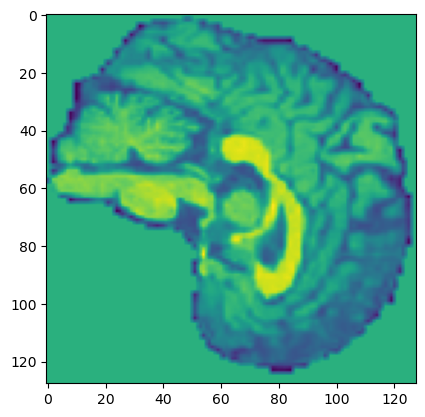

In [5]:
# IXI dataset sample

ixi_hdbet_list = glob.glob("/SSD/qasymjomart/IXI-T1/hdbet/IXI*/*1.nii.gz")
print(ixi_hdbet_list[0], len(ixi_hdbet_list))

ixi_list = ixi_hdbet_list[120]

x = nib.load(ixi_list).get_fdata()
print(x.shape)

plt.imshow(x[::-1, :, 75], cmap='gray')

x_ = x[x != 0]
print(x_.shape)
sub_ = _mean(x_)
div_ = _std(x_)

print(sub_, div_)

# Test MONAI data augmentations

datapath_list = ixi_hdbet_list
dataset_list = []
for data_path in datapath_list:
    dataset_list.append({"image": data_path})

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=["image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image",]),
    monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
    monai.transforms.Spacingd(keys=["image"], pixdim=(1.75,1.75,1.75)),
    monai.transforms.CropForegroundd(keys=["image"], source_key="image"), 
    monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
    monai.transforms.Resized(keys=["image"], spatial_size=(128, 128, 128)),
    monai.transforms.ToTensord(keys=["image"])
])

x = train_transforms(dataset_list[454])

print(x['image'].shape)

plt.imshow(x['image'][0, 64, :, :])

In [6]:
# xc = x['image']
# print(xc.shape)
# xn = torch.where(xc != 0, xc * div_ + sub_, xc)
# # xn = xc.numpy() * div_ + sub_
# # xn = xn.reshapes(1, 128, 128, 128)
# print(xn.shape)
# plt.imshow(xn[0, 64, :, :], cmap='gray')

In [7]:
yr75 = mae_model75(torch.unsqueeze(x["image"][:, :, :, :], 1), mask_ratio=0.75)
print(yr75[0])
u_yr75 = mae_model75.unpatchify3D(yr75[1])

tensor(0.4881, grad_fn=<AliasBackward0>)


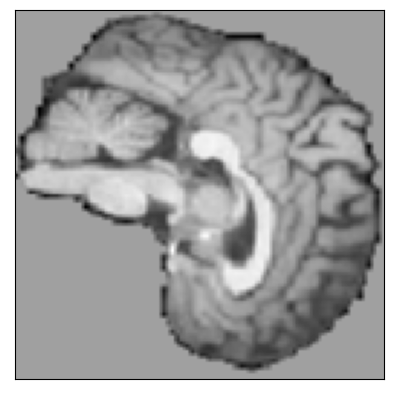

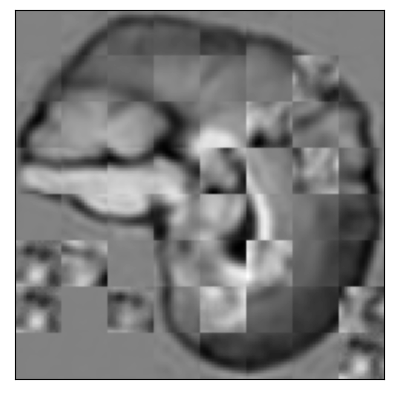

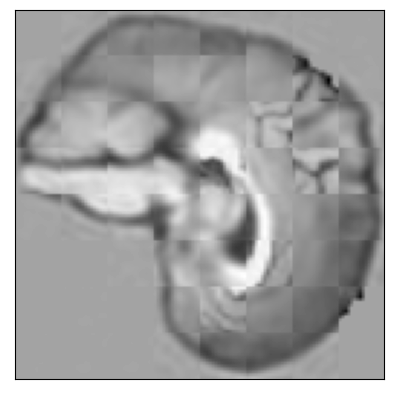

([], [])

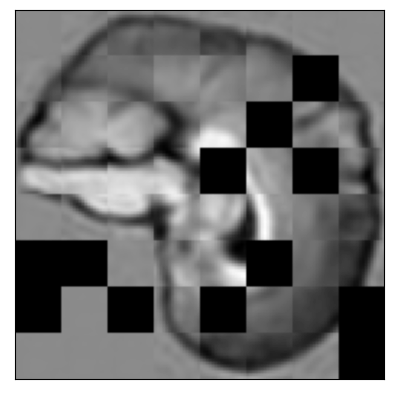

In [8]:
image_id = 65

plt.xticks([])
plt.yticks([])
# plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
# plt.show(block=True)
# x["image"] = torch.where(x["image"] != 0, x["image"] * div_ + sub_, x["image"])
# u_yr75 = torch.where(u_yr75 != 0, u_yr75 * div_ + sub_, u_yr75)
# u_yr75[0, 0, image_id] = u_yr75[0, 0, image_id] * div_ + sub_

plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(u_yr75[0, 0, image_id, :, :].detach().numpy(), cmap='gray')

yc75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = x["image"][0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yc75[0, :, :].detach().numpy(), cmap='gray')

yb75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id].min()

plt.show(block=True)
plt.imshow(yb75[0, :, :].detach().numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

In [9]:
r = yr75[2].reshape(8, 8, 8)

In [10]:
r[4]

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.]])

# HCP

/SSD/qasymjomart/HCP/hdbet/700634_3T_T1w_MPR1/hdbet_n4_700634_3T_T1w_MPR1.nii.gz 1113
(256, 320, 320)
(4807785,)
709.3880694588431 186.8255187087428


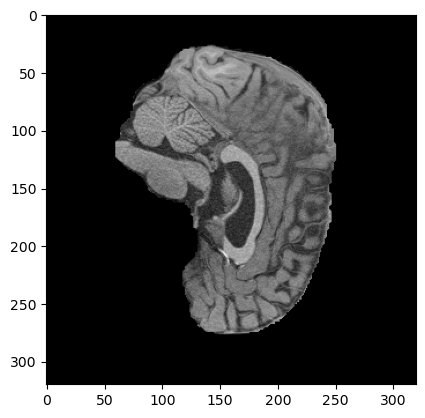

In [11]:
# HCP dataset sample

hcp_hdbet_list = glob.glob("/SSD/qasymjomart/HCP/hdbet/*/hdbet_n4*1.nii.gz")
print(hcp_hdbet_list[0], len(hcp_hdbet_list))

hcp_list = hcp_hdbet_list[120]

x = nib.load(hcp_list).get_fdata()
print(x.shape)

plt.imshow(x[128, :, :], cmap='gray')

x_ = x[x != 0]
print(x_.shape)
sub_ = _mean(x_)
div_ = _std(x_)

print(sub_, div_)

torch.Size([1, 128, 128, 128])


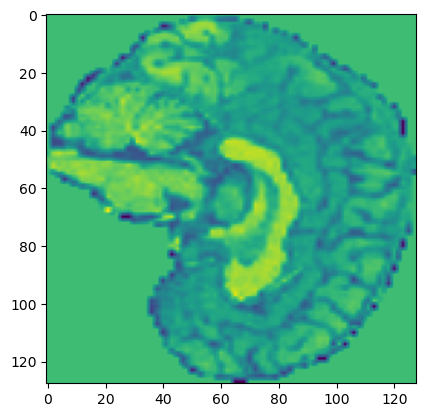

In [12]:
# Test MONAI data augmentations

datapath_list = hcp_hdbet_list
dataset_list = []
for data_path in datapath_list:
    dataset_list.append({"image": data_path})

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=["image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image",]),
    monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
    monai.transforms.Spacingd(keys=["image"], pixdim=(1.75,1.75,1.75)),
    monai.transforms.CropForegroundd(keys=["image"], source_key="image"), 
    monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
    monai.transforms.Resized(keys=["image"], spatial_size=(128, 128, 128)),
    monai.transforms.ToTensord(keys=["image"])
])

x = train_transforms(dataset_list[454])

print(x['image'].shape)

plt.imshow(x['image'][0, 64, :, :])

In [13]:
yr75 = mae_model75(torch.unsqueeze(x["image"][:, :, :, :], 1), mask_ratio=0.75)
print(yr75[0])
u_yr75 = mae_model75.unpatchify3D(yr75[1])

tensor(0.4454, grad_fn=<AliasBackward0>)


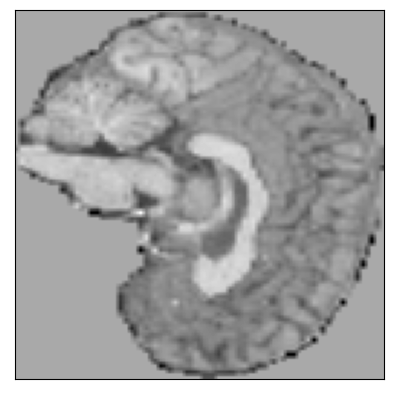

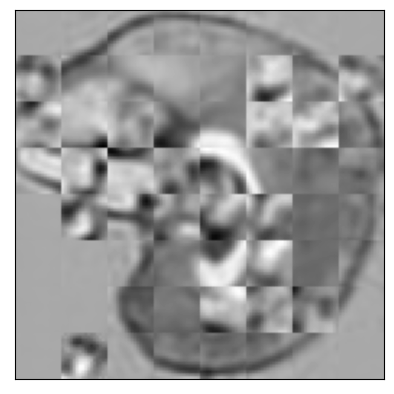

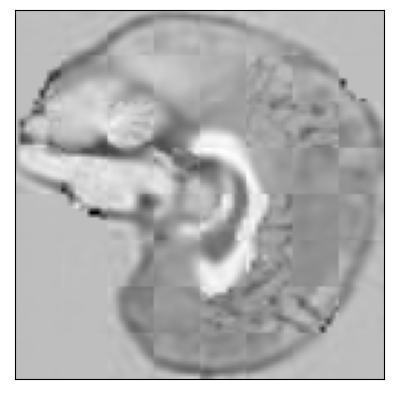

([], [])

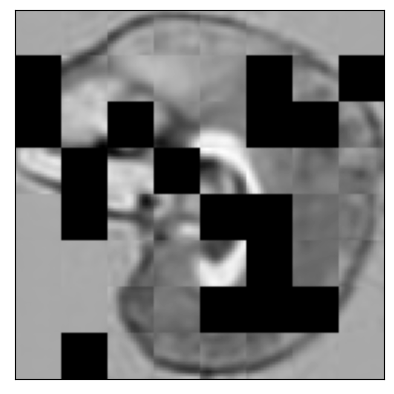

In [14]:
image_id = 65

plt.xticks([])
plt.yticks([])
# plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
# plt.show(block=True)
# x["image"] = torch.where(x["image"] != 0, x["image"] * div_ + sub_, x["image"])
# u_yr75 = torch.where(u_yr75 != 0, u_yr75 * div_ + sub_, u_yr75)

plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(u_yr75[0, 0, image_id, :, :].detach().numpy(), cmap='gray')

yc75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = x["image"][0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yc75[0, :, :].detach().numpy(), cmap='gray')

yb75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id].min()

plt.show(block=True)
plt.imshow(yb75[0, :, :].detach().numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

# ADNI1 AD

Total number of files found:  818
/home/qasymjomart/uda/data/ADNI1_preprocessed_arranged/130_S_1290/hdbet_ADNI1_130_S_1290_I63766.nii.gz
Data shape:  (256, 256, 166)
Data shape after transpose:  (256, 166, 256)


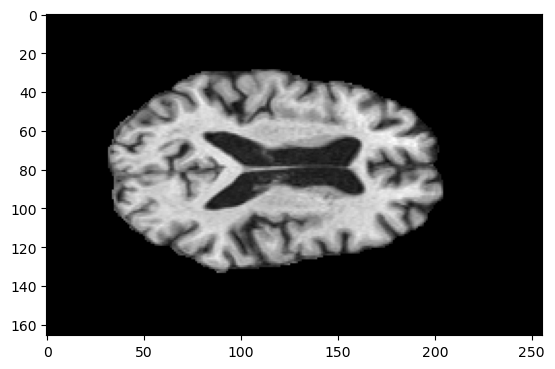

(1190228,)
377.8410791555829 144.81438836546866
torch.Size([1, 128, 128, 128])


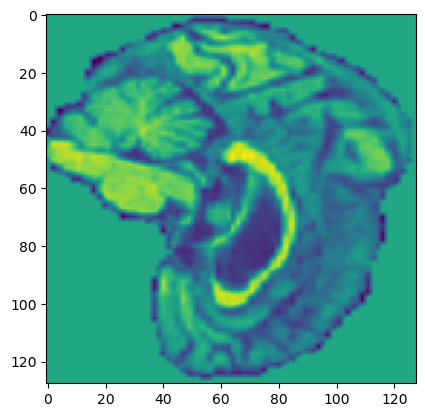

In [15]:
prefix = 'hdbet'

ADNI1_15T_UNIQUE = pd.read_csv('/home/qasymjomart/uda/data/ADNI1_15T_UNIQUE.csv')

subjects_list = set(ADNI1_15T_UNIQUE.Subject)
folders_list = glob.glob('/home/qasymjomart/uda/data/ADNI1_preprocessed_arranged/*/'+prefix+'*[!mask].nii.gz')
print('Total number of files found: ', len(folders_list))

files_list = [x.split('/')[-1] for x in folders_list]

# print(folders_list[72])
# MCI 941_S_1311
# AD 130_S_1337, 130_S_1290
# CN 131_S_0319

# AD
subj = '130_S_1290'
id_ = ADNI1_15T_UNIQUE[ADNI1_15T_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
print(path_to_file)

data = nib.load(path_to_file).get_fdata()
print('Data shape: ', data.shape)

data = data.transpose(0, 2, 1)
data = np.flip(data, (1,2))
print('Data shape after transpose: ', data.shape)

plt.imshow(data[100, :, :], cmap='gray')

plt.show(block=True)

x_ = data[data != 0]
print(x_.shape)
sub_ = _mean(x_)
div_ = _std(x_)

print(sub_, div_)

# Test MONAI data augmentations

datapath_list = [path_to_file]
dataset_list = []
for data_path in datapath_list:
    dataset_list.append({"image": data_path})

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=["image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image",]),
    monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
    monai.transforms.Spacingd(keys=["image"], pixdim=(1.75,1.75,1.75)),
    monai.transforms.CropForegroundd(keys=["image"], source_key="image"), 
    monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
    monai.transforms.Resized(keys=["image"], spatial_size=(128, 128, 128)),
    monai.transforms.ToTensord(keys=["image"])
])

x = train_transforms(dataset_list[0])

print(x['image'].shape)

plt.imshow(x['image'][0, 64, :, :])

# MCI
# subj = '941_S_1311'
# id_ = ADNI1_15T_UNIQUE[ADNI1_15T_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

# path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
# print(path_to_file)

# data = nib.load(path_to_file).get_fdata()
# print('Data shape: ', data.shape)

# data = data.transpose(0, 2, 1)
# data = np.flip(data, (1,2))
# print('Data shape after transpose: ', data.shape)

# plt.imshow(data[100, :, :], cmap='gray')

# plt.show(block=True)

# # CN
# subj = '131_S_0319'
# id_ = ADNI1_15T_UNIQUE[ADNI1_15T_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

# path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
# print(path_to_file)

# data = nib.load(path_to_file).get_fdata()
# print('Data shape: ', data.shape)

# data = data.transpose(0, 2, 1)
# data = np.flip(data, (1,2))
# print('Data shape after transpose: ', data.shape)

# plt.imshow(data[100, :, :], cmap='gray')

In [16]:
yr75 = mae_model75(torch.unsqueeze(x["image"][:, :, :, :], 1), mask_ratio=0.75)
print(yr75[0])
u_yr75 = mae_model75.unpatchify3D(yr75[1])

tensor(0.5935, grad_fn=<AliasBackward0>)


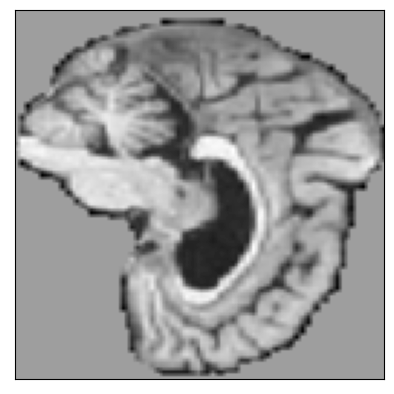

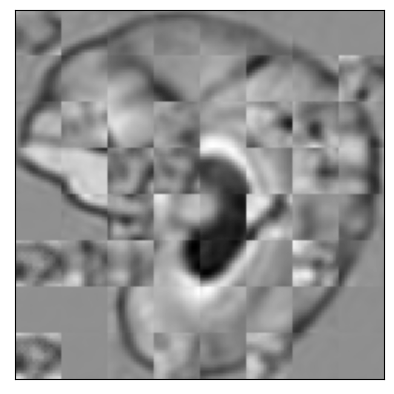

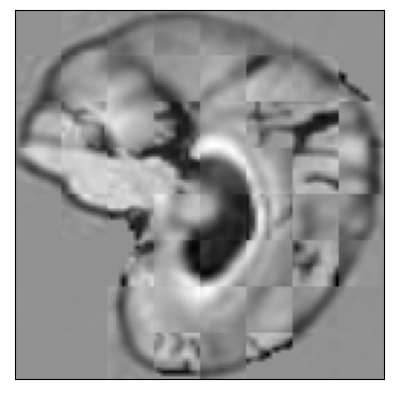

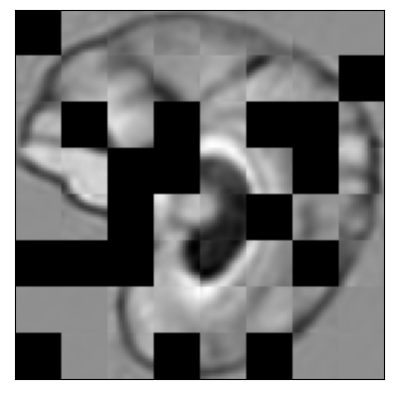

In [17]:
image_id = 68
plt.xticks([])
plt.yticks([])
# plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
# plt.show(block=True)
# x["image"] = torch.where(x["image"] != 0, x["image"] * div_ + sub_, x["image"])
# u_yr75 = torch.where(u_yr75 != 0, u_yr75 * div_ + sub_, u_yr75)

plt.xticks([])
plt.yticks([])
plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(u_yr75[0, 0, image_id, :, :].detach().numpy(), cmap='gray')

yc75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = x["image"][0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yc75[0, :, :].detach().numpy(), cmap='gray')

yb75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id].min()

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yb75[0, :, :].detach().numpy(), cmap='gray')

# ADNI1 CN

Total number of files found:  818
/home/qasymjomart/uda/data/ADNI1_preprocessed_arranged/131_S_0319/hdbet_ADNI1_131_S_0319_I47984.nii.gz
Data shape:  (256, 256, 166)
Data shape after transpose:  (256, 166, 256)
(1188527,)
557.6326619926625 180.29315975718245
torch.Size([1, 128, 128, 128])


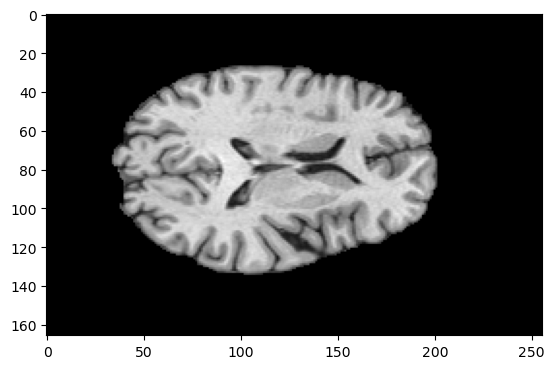

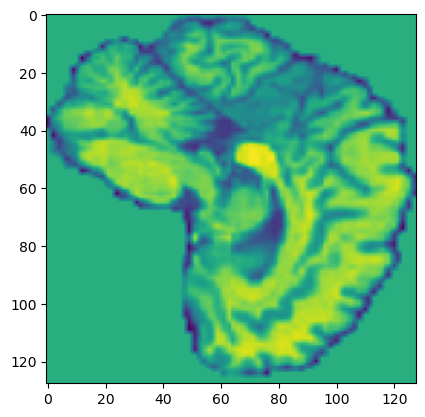

In [30]:
prefix = 'hdbet'

ADNI1_15T_UNIQUE = pd.read_csv('/home/qasymjomart/uda/data/ADNI1_15T_UNIQUE.csv')

subjects_list = set(ADNI1_15T_UNIQUE.Subject)
folders_list = glob.glob('/home/qasymjomart/uda/data/ADNI1_preprocessed_arranged/*/'+prefix+'*[!mask].nii.gz')
print('Total number of files found: ', len(folders_list))

files_list = [x.split('/')[-1] for x in folders_list]

# print(folders_list[72])
# MCI 941_S_1311
# AD 130_S_1337
# CN 131_S_0319

# AD
# subj = '130_S_1337'
# id_ = ADNI1_15T_UNIQUE[ADNI1_15T_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

# path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
# print(path_to_file)

# data = nib.load(path_to_file).get_fdata()
# print('Data shape: ', data.shape)

# data = data.transpose(0, 2, 1)
# data = np.flip(data, (1,2))
# print('Data shape after transpose: ', data.shape)

# plt.imshow(data[100, :, :], cmap='gray')

# plt.show(block=True)

# MCI
# subj = '941_S_1311'
# id_ = ADNI1_15T_UNIQUE[ADNI1_15T_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

# path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
# print(path_to_file)

# data = nib.load(path_to_file).get_fdata()
# print('Data shape: ', data.shape)

# data = data.transpose(0, 2, 1)
# data = np.flip(data, (1,2))
# print('Data shape after transpose: ', data.shape)

# plt.imshow(data[100, :, :], cmap='gray')

# plt.show(block=True)

# # CN
subj = '131_S_0319'
id_ = ADNI1_15T_UNIQUE[ADNI1_15T_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
print(path_to_file)

data = nib.load(path_to_file).get_fdata()
print('Data shape: ', data.shape)

data = data.transpose(0, 2, 1)
data = np.flip(data, (1,2))
print('Data shape after transpose: ', data.shape)

plt.imshow(data[100, :, :], cmap='gray')

x_ = data[data != 0]
print(x_.shape)
sub_ = _mean(x_)
div_ = _std(x_)

print(sub_, div_)

# Test MONAI data augmentations

datapath_list = [path_to_file]
dataset_list = []
for data_path in datapath_list:
    dataset_list.append({"image": data_path})

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=["image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image",]),
    monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
    monai.transforms.Spacingd(keys=["image"], pixdim=(1.75,1.75,1.75)),
    monai.transforms.CropForegroundd(keys=["image"], source_key="image"), 
    monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
    monai.transforms.Resized(keys=["image"], spatial_size=(128, 128, 128)),
    monai.transforms.ToTensord(keys=["image"])
])

x = train_transforms(dataset_list[0])

print(x['image'].shape)

plt.show(block=True)
plt.imshow(x['image'][0, 64, :, :])

In [31]:
yr75 = mae_model75(torch.unsqueeze(x["image"][:, :, :, :], 1), mask_ratio=0.75)
print(yr75[0])
u_yr75 = mae_model75.unpatchify3D(yr75[1])

tensor(0.6522, grad_fn=<AliasBackward0>)


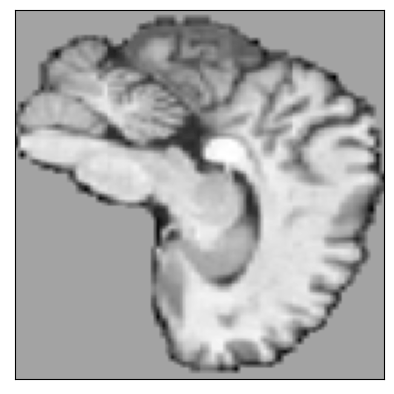

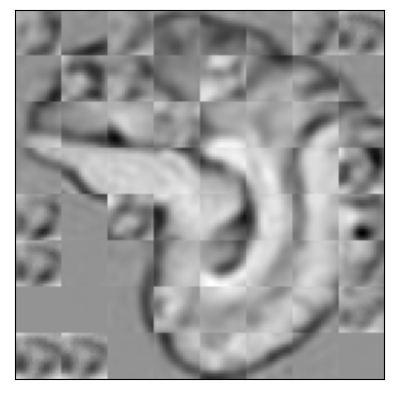

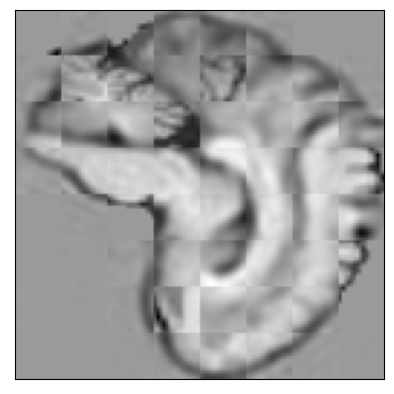

([], [])

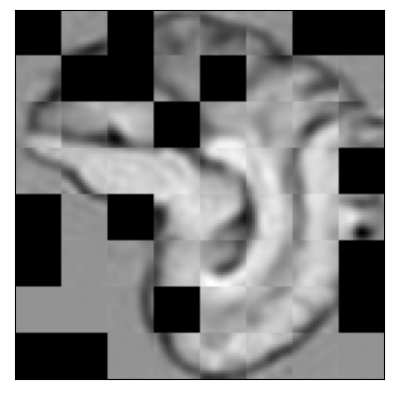

In [32]:
image_id = 68

plt.xticks([])
plt.yticks([])
# plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
# plt.show(block=True)
# x["image"] = torch.where(x["image"] != 0, x["image"] * div_ + sub_, x["image"])
# u_yr75 = torch.where(u_yr75 != 0, u_yr75 * div_ + sub_, u_yr75)

plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(u_yr75[0, 0, image_id, :, :].detach().numpy(), cmap='gray')

yc75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = x["image"][0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yc75[0, :, :].detach().numpy(), cmap='gray')

yb75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id].min()

plt.show(block=True)
plt.imshow(yb75[0, :, :].detach().numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

# ADNI2 AD

Total number of files found:  839
/home/qasymjomart/uda/data/ADNI2/005_S_5119/hdbet_ADNI2_005_S_5119_I369214.nii.gz
Data shape:  (196, 256, 256)
Data shape after transpose:  (196, 256, 256)


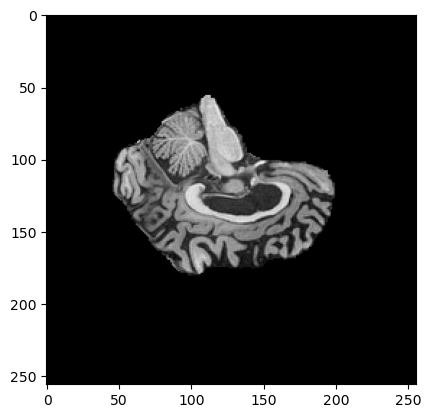

(953546,)
1309.5843607703785 568.2082456211365
torch.Size([1, 128, 128, 128])


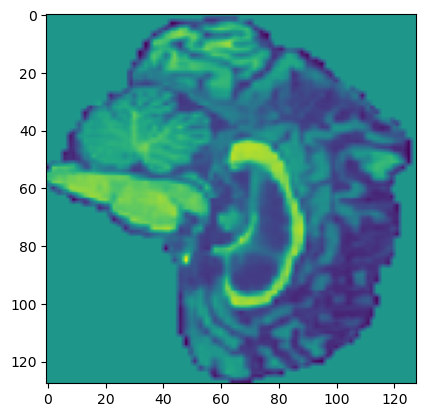

In [21]:
prefix = 'hdbet_'

ADNI2_UNIQUE = pd.read_csv('/home/qasymjomart/uda/data/adni2_unique_sorted_22012023.csv')

subjects_list = set(ADNI2_UNIQUE.Subject)
folders_list = glob.glob('/home/qasymjomart/uda/data/ADNI2/*/'+prefix+'*[!mask].nii.gz')
print('Total number of files found: ', len(folders_list))

files_list = [x.split('/')[-1] for x in folders_list]

# print(folders_list[72])

slice_ii = 100

# AD 005_S_5119
# MCI 130_S_4605
# CN 136_S_4727

# AD
subj = '005_S_5119'
id_ = ADNI2_UNIQUE[ADNI2_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
print(path_to_file)

data = nib.load(path_to_file).get_fdata()
print('Data shape: ', data.shape)

data = data.transpose(0, 2, 1)
print('Data shape after transpose: ', data.shape)

plt.imshow(data[slice_ii, :, :], cmap='gray')

plt.show(block=True)

x_ = data[data != 0]
print(x_.shape)
sub_ = _mean(x_)
div_ = _std(x_)

print(sub_, div_)

# Test MONAI data augmentations

datapath_list = [path_to_file]
dataset_list = []
for data_path in datapath_list:
    dataset_list.append({"image": data_path})

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=["image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image",]),
    monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
    monai.transforms.Spacingd(keys=["image"], pixdim=(1.75,1.75,1.75)),
    monai.transforms.CropForegroundd(keys=["image"], source_key="image"), 
    monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
    monai.transforms.Resized(keys=["image"], spatial_size=(128, 128, 128)),
    monai.transforms.ToTensord(keys=["image"])
])

x = train_transforms(dataset_list[0])

print(x['image'].shape)

plt.show(block=True)
plt.imshow(x['image'][0, 64, :, :])

In [22]:
yr75 = mae_model75(torch.unsqueeze(x["image"][:, :, :, :], 1), mask_ratio=0.75)
print(yr75[0])
u_yr75 = mae_model75.unpatchify3D(yr75[1])

tensor(0.6015, grad_fn=<AliasBackward0>)


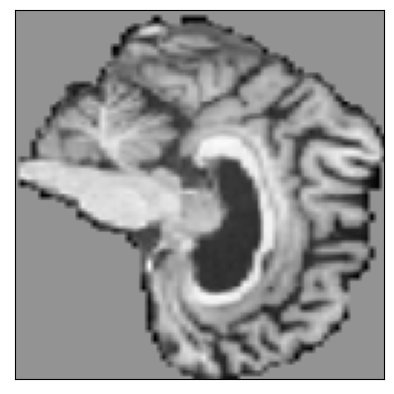

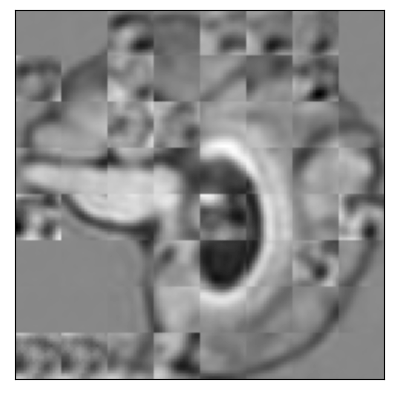

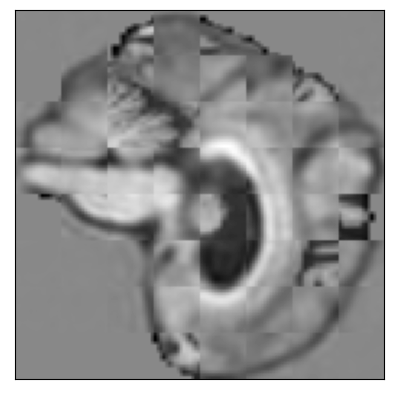

([], [])

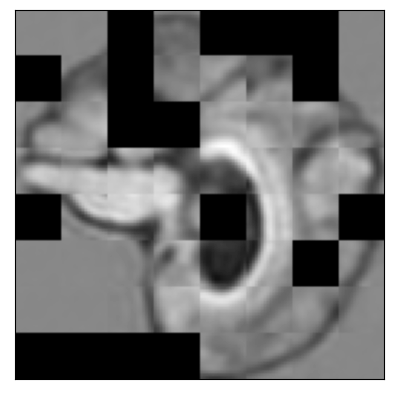

In [23]:
image_id = 68

plt.xticks([])
plt.yticks([])
# plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
# plt.show(block=True)
# x["image"] = torch.where(x["image"] != 0, x["image"] * div_ + sub_, x["image"])
# u_yr75 = torch.where(u_yr75 != 0, u_yr75 * div_ + sub_, u_yr75)

plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(u_yr75[0, 0, image_id, :, :].detach().numpy(), cmap='gray')

yc75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = x["image"][0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yc75[0, :, :].detach().numpy(), cmap='gray')

yb75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id].min()

plt.show(block=True)
plt.imshow(yb75[0, :, :].detach().numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

# ADNI2 CN

Total number of files found:  839
/home/qasymjomart/uda/data/ADNI2/128_S_4607/hdbet_ADNI2_128_S_4607_I295859.nii.gz
Data shape:  (176, 240, 256)
Data shape after transpose:  (176, 256, 240)
(1129322,)
229.84696945608283 77.31507239238522
torch.Size([1, 128, 128, 128])


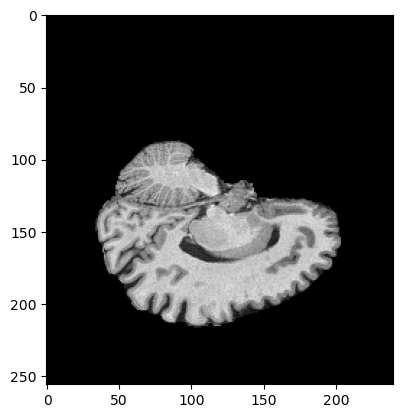

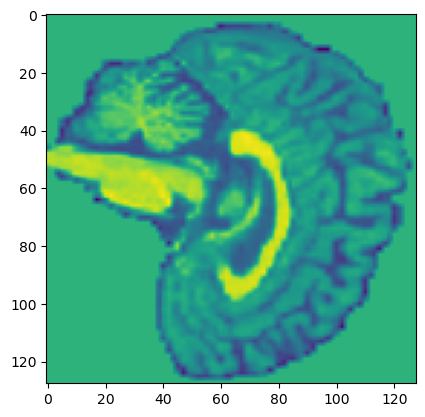

In [41]:
prefix = 'hdbet_'

ADNI2_UNIQUE = pd.read_csv('/home/qasymjomart/uda/data/adni2_unique_sorted_22012023.csv')

subjects_list = set(ADNI2_UNIQUE.Subject)
folders_list = glob.glob('/home/qasymjomart/uda/data/ADNI2/*/'+prefix+'*[!mask].nii.gz')
print('Total number of files found: ', len(folders_list))

files_list = [x.split('/')[-1] for x in folders_list]

# print(folders_list[72])

slice_ii = 100

# AD 005_S_5119
# MCI 130_S_4605
# CN 136_S_4727, 041_S_4200, 098_S_4002, 041_S_4014, 128_S_4607


# CN
subj = '128_S_4607'
id_ = ADNI2_UNIQUE[ADNI2_UNIQUE.Subject == subj]['Image Data ID'].to_list()[0]

path_to_file = [x for x in folders_list if subj in x and id_ in x][0]
print(path_to_file)

data = nib.load(path_to_file).get_fdata()
print('Data shape: ', data.shape)

data = data.transpose(0, 2, 1)
print('Data shape after transpose: ', data.shape)

plt.imshow(data[slice_ii, :, :], cmap='gray')

x_ = data[data != 0]
print(x_.shape)
sub_ = _mean(x_)
div_ = _std(x_)

print(sub_, div_)

# Test MONAI data augmentations

datapath_list = [path_to_file]
dataset_list = []
for data_path in datapath_list:
    dataset_list.append({"image": data_path})

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=["image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image",]),
    monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
    monai.transforms.Spacingd(keys=["image"], pixdim=(1.75,1.75,1.75)),
    monai.transforms.CropForegroundd(keys=["image"], source_key="image"), 
    monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
    monai.transforms.Resized(keys=["image"], spatial_size=(128, 128, 128)),
    monai.transforms.ToTensord(keys=["image"])
])

x = train_transforms(dataset_list[0])

print(x['image'].shape)

plt.show(block=True)
plt.imshow(x['image'][0, 64, :, :])

In [42]:
yr75 = mae_model75(torch.unsqueeze(x["image"][:, :, :, :], 1), mask_ratio=0.75)
print(yr75[0])
u_yr75 = mae_model75.unpatchify3D(yr75[1])

tensor(0.5824, grad_fn=<AliasBackward0>)


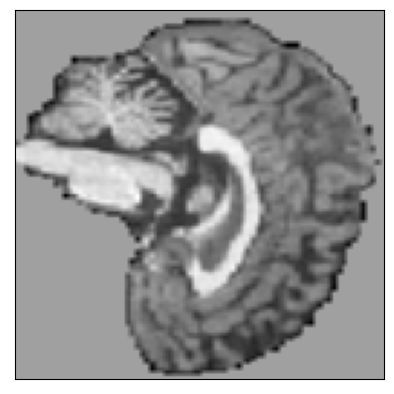

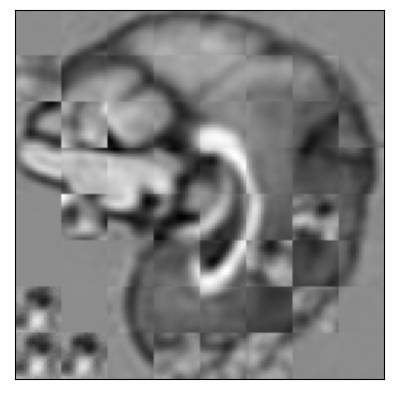

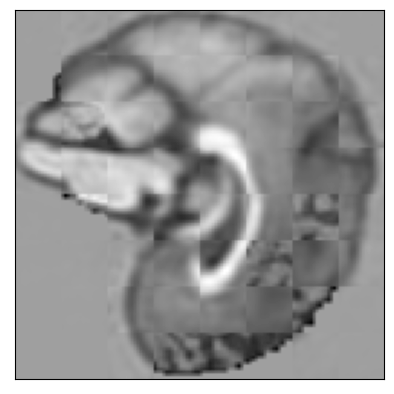

([], [])

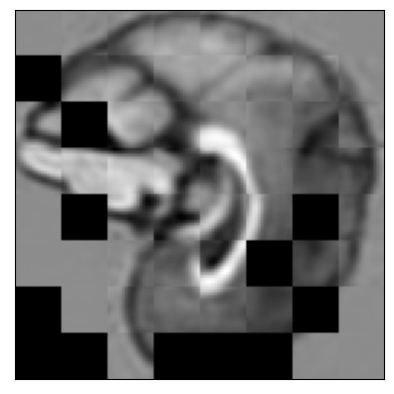

In [43]:
image_id = 65

plt.xticks([])
plt.yticks([])

# plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
# plt.show(block=True)
# x["image"] = torch.where(x["image"] != 0, x["image"] * div_ + sub_, x["image"])
# u_yr75 = torch.where(u_yr75 != 0, u_yr75 * div_ + sub_, u_yr75)

plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(u_yr75[0, 0, image_id, :, :].detach().numpy(), cmap='gray')

yc75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = x["image"][0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yc75[0, :, :].detach().numpy(), cmap='gray')

yb75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id].min()

plt.show(block=True)
plt.imshow(yb75[0, :, :].detach().numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

# OASIS3

Total number of files found:  815
sub-OAS30571_ses-d0120_run-01_T1w
/home/qasymjomart/uda/data/OASIS3/scans/sub-OAS30571/ses-d0120/anat/hdbet_sub-OAS30571_ses-d0120_run-01_T1w.nii.gz
Data shape:  (176, 256, 256)
(1167943,)
222.63551988410393 82.51509351318529
torch.Size([1, 128, 128, 128])


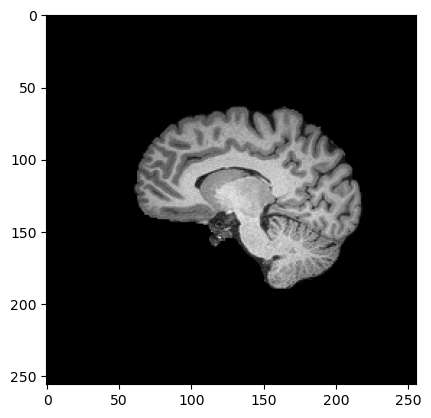

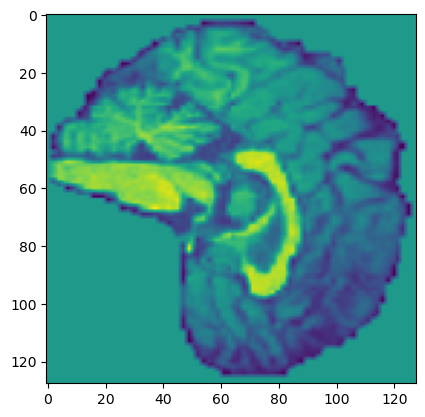

In [27]:
prefix = 'hdbet'

OASIS3_UNIQUE = pd.read_csv('/home/qasymjomart/uda/data/OASIS3_CLOSEST_LABELS.csv')

subjects_list = set(OASIS3_UNIQUE.OASISID)
folders_list = glob.glob('/home/qasymjomart/uda/data/OASIS3/scans/*/*/*/'+prefix+'*[!mask].nii.gz')
print('Total number of files found: ', len(folders_list))

files_list = [x.split('/')[-1] for x in folders_list]

# AD OAS30198
# MCI OAS30672
# CN OAS30571

# # AD
# subj_id = 'OAS30198'
# file_name = OASIS3_UNIQUE[OASIS3_UNIQUE.OASISID == subj_id]['filename'].to_list()[0][:-5]
# print(file_name)

# path_to_file = [x for x in folders_list if file_name in x][0]
# print(path_to_file)

# data = nib.load(path_to_file).get_fdata()
# print('Data shape: ', data.shape)

# mni_data = data.transpose(0, 2, 1)
# plt.imshow(mni_data[96, ::-1, ::-1], cmap='gray')

# plt.show(block=True)

# # MCI
# subj_id = 'OAS30672'
# file_name = OASIS3_UNIQUE[OASIS3_UNIQUE.OASISID == subj_id]['filename'].to_list()[0][:-5]
# print(file_name)

# path_to_file = [x for x in folders_list if file_name in x][0]
# print(path_to_file)

# data = nib.load(path_to_file).get_fdata()
# print('Data shape: ', data.shape)

# mni_data = data.transpose(0, 2, 1)
# plt.imshow(mni_data[96, ::-1, ::-1], cmap='gray')

plt.show(block=True)


# CN
subj_id = 'OAS30571'
file_name = OASIS3_UNIQUE[OASIS3_UNIQUE.OASISID == subj_id]['filename'].to_list()[0][:-5]
print(file_name)

path_to_file = [x for x in folders_list if file_name in x][0]
print(path_to_file)

data = nib.load(path_to_file).get_fdata()
print('Data shape: ', data.shape)

mni_data = data.transpose(0, 2, 1)
plt.imshow(mni_data[96, ::-1, ::-1], cmap='gray')

x_ = data[data != 0]
print(x_.shape)
sub_ = _mean(x_)
div_ = _std(x_)

print(sub_, div_)

# Test MONAI data augmentations

datapath_list = [path_to_file]
dataset_list = []
for data_path in datapath_list:
    dataset_list.append({"image": data_path})

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=["image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image",]),
    monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
    monai.transforms.Spacingd(keys=["image"], pixdim=(1.75,1.75,1.75)),
    monai.transforms.CropForegroundd(keys=["image"], source_key="image"), 
    monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
    monai.transforms.Resized(keys=["image"], spatial_size=(128, 128, 128)),
    monai.transforms.ToTensord(keys=["image"])
])

x = train_transforms(dataset_list[0])

print(x['image'].shape)

plt.show(block=True)
plt.imshow(x['image'][0, 64, :, :])

In [28]:
yr75 = mae_model75(torch.unsqueeze(x["image"][:, :, :, :], 1), mask_ratio=0.75)
print(yr75[0])
u_yr75 = mae_model75.unpatchify3D(yr75[1])

tensor(0.4785, grad_fn=<AliasBackward0>)


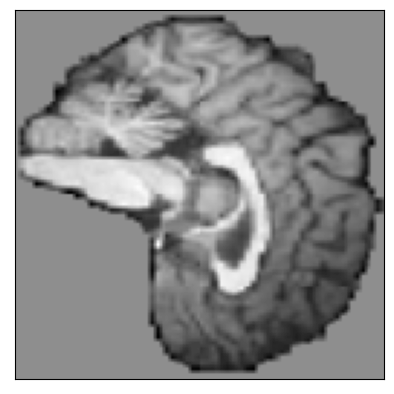

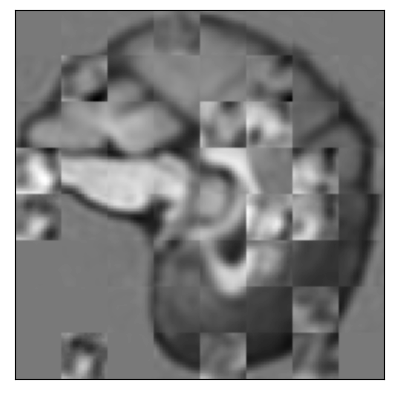

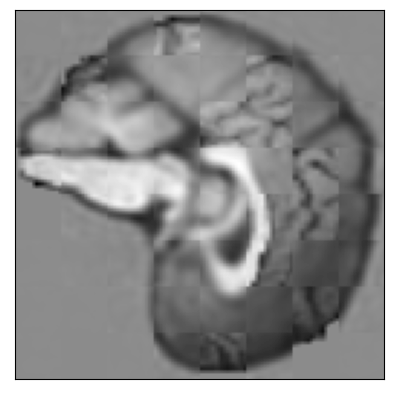

([], [])

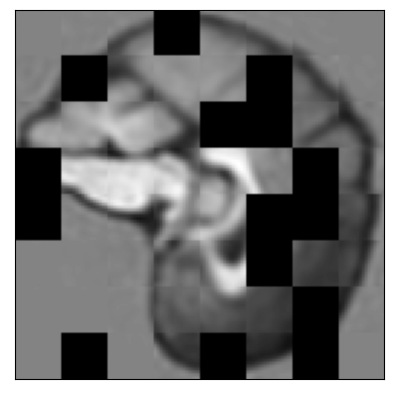

In [29]:
image_id = 65

plt.xticks([])
plt.yticks([])
# plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
# plt.show(block=True)
# x["image"] = torch.where(x["image"] != 0, x["image"] * div_ + sub_, x["image"])
# u_yr75 = torch.where(u_yr75 != 0, u_yr75 * div_ + sub_, u_yr75)

plt.imshow(x["image"][0, image_id, :, :].detach().numpy(), cmap='gray')
plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(u_yr75[0, 0, image_id, :, :].detach().numpy(), cmap='gray')

yc75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yc75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = x["image"][0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]

plt.show(block=True)
plt.xticks([])
plt.yticks([])
plt.imshow(yc75[0, :, :].detach().numpy(), cmap='gray')

yb75 = torch.zeros((1,128,128))

r = yr75[2].reshape(8, 8, 8)

for ii in range(r[4].shape[0]):
    for jj in range(r[4].shape[1]):
        if r[4][ii,jj] == 1:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id, ii*16:(ii+1)*16, jj*16:(jj+1)*16]
        elif r[4][ii,jj] == 0:
            yb75[0, ii*16:(ii+1)*16, jj*16:(jj+1)*16] = u_yr75[0, 0, image_id].min()

plt.show(block=True)
plt.imshow(yb75[0, :, :].detach().numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])